### Coding Challenge - Sounding Data

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT, Hodograph
from siphon.simplewebservice.wyoming import WyomingUpperAir

This example uses siphon to pull sounding data from the UWyoming archive.  
More on the siphon package: https://unidata.github.io/siphon/latest/index.html

#### Part 1: Data Request

In [2]:
date = datetime(2021, 10, 13, 0)
station = 'DDC'
raw_df = WyomingUpperAir.request_data(date, station)

In [3]:
df = raw_df[raw_df['pressure']>100.] # Don't plot obs above 100 mb
df.units = raw_df.units # Preserve the data attribute
df

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,914.0,790,17.4,15.2,120.0,18.0,-15.588457,9.000000,DDC,72451,2021-10-13,37.76,-99.97,790.0,19.39
1,900.0,922,15.6,14.0,129.0,24.0,-18.651503,15.103689,DDC,72451,2021-10-13,37.76,-99.97,790.0,19.39
2,880.0,1113,14.2,13.8,143.0,34.0,-20.461711,27.153607,DDC,72451,2021-10-13,37.76,-99.97,790.0,19.39
3,869.1,1219,14.0,13.6,150.0,39.0,-19.500000,33.774991,DDC,72451,2021-10-13,37.76,-99.97,790.0,19.39
4,850.0,1407,13.6,13.3,160.0,38.0,-12.996765,35.708320,DDC,72451,2021-10-13,37.76,-99.97,790.0,19.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,127.4,14935,-57.3,-89.2,240.0,55.0,47.631397,27.500000,DDC,72451,2021-10-13,37.76,-99.97,790.0,19.39
62,127.0,14954,-57.1,-89.1,239.0,54.0,46.287034,27.812056,DDC,72451,2021-10-13,37.76,-99.97,790.0,19.39
63,125.0,15055,-56.9,-88.9,234.0,50.0,40.450850,29.389263,DDC,72451,2021-10-13,37.76,-99.97,790.0,19.39
64,121.3,15240,-58.1,-89.6,225.0,43.0,30.405592,30.405592,DDC,72451,2021-10-13,37.76,-99.97,790.0,19.39


#### Part 2: Basic Plot
We'll create a basic plot of potential temperature vs height. Since theta is not a variable in the dataframe, use metpy's calculations to easily calculate it.

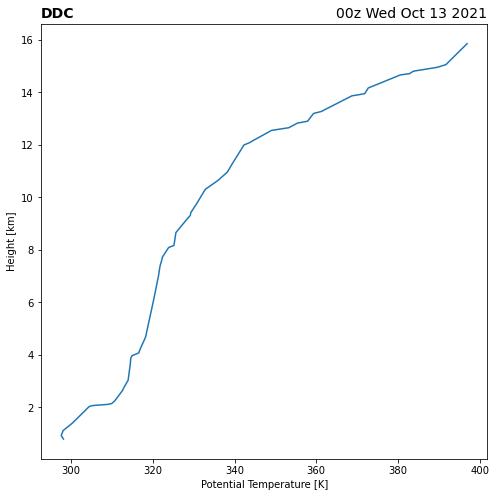

In [4]:
# Prepare data
hgt = (df['height'].values*units(df.units['height'])).to('km')
theta = mpcalc.potential_temperature(df['pressure'].values*units(df.units['pressure']),
                                     df['temperature'].values*units(df.units['temperature'])).to('K')

# The plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(theta, hgt)
ax.set_ylabel('Height [km]')
ax.set_xlabel('Potential Temperature [K]')
ax.set_title(station, loc='left', fontweight='bold', fontsize=14)
ax.set_title(date.strftime('%Hz %a %b %d %Y'), loc='right', fontsize=14)
plt.show()

#### Part 3: Skew-T
We often want to look at sounding data on a Skew-T. Metpy's Skew-T layout makes these plots easy.  
More about metpy: https://unidata.github.io/MetPy/latest/userguide/index.html

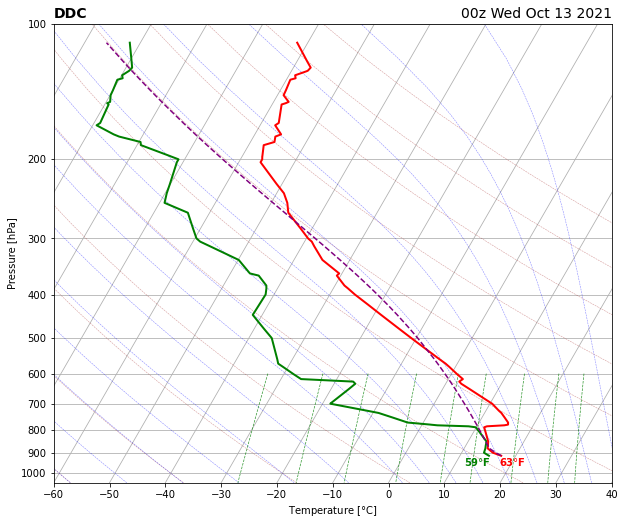

In [5]:
# Set up the figure
fig = plt.figure(figsize=(10,10))
skewt = SkewT(fig=fig)
skewt.ax.set_xlim(-60,40)
skewt.ax.set_xlabel('Temperature [$\degree$C]')
skewt.ax.set_ylabel('Pressure [hPa]')

# Lines
skewt.plot_dry_adiabats(t0=np.arange(-60,160,20)*units('degC'), colors='brown', linewidths=0.5, linestyles='dashed')
skewt.plot_moist_adiabats(colors='blue', linewidths=0.5, linestyles='dashed')
skewt.plot_mixing_lines(linewidths=0.7)

# Calculations for plotting quantities - make sure of correct units
temp = (df['temperature'].values*units(df.units['temperature'])).to('degC')
dew = (df['dewpoint'].values*units(df.units['dewpoint'])).to('degC')
pres = (df['pressure'].values*units(df.units['pressure'])).to('hPa')
parcel_t = (mpcalc.parcel_profile(pres, temp[0], dew[0])).to('degC')

# Plot useful quantities
skewt.plot(pres, dew, color='green', linewidth=2)
skewt.plot(pres, temp, color='red', linewidth=2)
skewt.plot(pres, parcel_t, color='purple', linewidth=1.5, linestyle='dashed')
# Plot data readout for near-surface values
skewt.ax.text(temp[0].magnitude+2, pres[0].magnitude,
              str(int(np.rint(temp[0].to('degF').magnitude)))+'$\degree$F',
              color='red', fontweight='bold', ha='center', va='top')
skewt.ax.text(dew[0].magnitude-2, pres[0].magnitude,
              str(int(np.rint(dew[0].to('degF').magnitude)))+'$\degree$F',
              color='green', fontweight='bold', ha='center', va='top')
# Titles
skewt.ax.set_title(station, loc='left', fontweight='bold', fontsize=14)
skewt.ax.set_title(date.strftime('%Hz %a %b %d %Y'), loc='right', fontsize=14)
plt.show()

#### Part 4: Hodograph
What about hodographs? Metpy has functionality for that too!

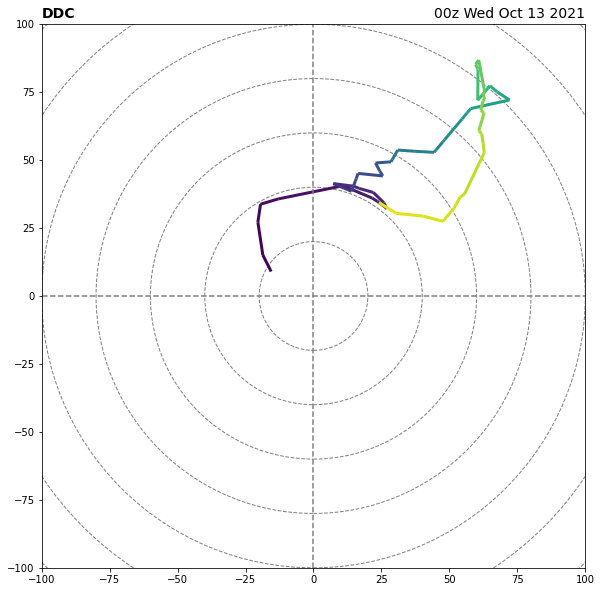

In [6]:
u = df['u_wind'].values*units(df.units['u_wind'])
v = df['v_wind'].values*units(df.units['v_wind'])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
h = Hodograph(ax, component_range=100.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, hgt)
h.ax.set_title(station, loc='left', fontweight='bold', fontsize=14)
h.ax.set_title(date.strftime('%Hz %a %b %d %Y'), loc='right', fontsize=14)
plt.show()

#### Coding Challenge Ideas
1. Add wind barbs to the Skew-T plot
2. Use MetPy calculations to calculate common skew-t variables and severe wx params (LCL, shear, lapse rates, etc)
3. Integrate the skew-t and hodograph plotting code with an interactive widget